<a href="https://colab.research.google.com/github/rpedram/data-science/blob/main/Capston_United_Airlines_ver_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Flight Delay Analysis

In [ ]:
import pandas as pd
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
#Import Libraries that I will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns # For additional visualizations
import gc # for garbage collection the colab ran over RAM in my runtime gc.collect()
# Import excel files into df from google drive
file_path = '/content/drive/My Drive/Dataset/'

# **1. Importing Data**
df=None
airlines_df = pd.read_excel(file_path+'Airlines.xlsx')
airports_df = pd.read_excel(file_path+'airports.xlsx')
runways_df = pd.read_excel(file_path+'runways.xlsx')
# Check import is correct
# Investigate data structures (modify column names if needed)
print(airlines_df.info())
print(airlines_df.shape)
print(airlines_df.head())
print(airports_df.info())
print(airports_df.shape)
print(airports_df.head())
print(runways_df.info())
print(runways_df.shape)
print(runways_df.head())

# dropping unnecesary columns
runways_df = runways_df.drop(['le_ident', 'le_latitude_deg','le_longitude_deg', 'le_elevation_ft', 'le_heading_degT',
       'le_displaced_threshold_ft', 'he_ident', 'he_latitude_deg','he_longitude_deg', 'he_elevation_ft', 'he_heading_degT',
       'he_displaced_threshold_ft'], axis = 1)

airports_df =airports_df.drop(['continent', 'iso_country', 'iso_region','municipality', 'gps_code','local_code', 'home_link',
                       'wikipedia_link', 'keywords'], axis=1)

# Join 1:  merge the runways and airport data.
df = pd.merge(airports_df, runways_df,how='left', left_on = "ident", right_on = "airport_ident")
df.head()
# Derive 'number_of_runways' Feature Engineering
df['number_of_runways'] = df.groupby('ident')['id_y'].transform('count')
df.isna().sum()
df.shape
df.drop(['id_x','id_y','surface'], axis=1, inplace=True)
# 2. Delete rows where 'Type' == 'closed'
df = df[df['type'] != 'closed']

# 3. Delete rows with null 'iata_code'
df = df[df['iata_code'].notnull()]
#  drop nulls in certain columns:
df['elevation_ft'] = df['elevation_ft'].fillna(0)  # Replace nulls in 'elevation_ft' with 0
df['length_ft'] = df['length_ft'].fillna(df['length_ft'].mean())  # Impute with mean
df['width_ft'] = df['width_ft'].fillna(df['length_ft'].mean())  # Impute with mean
# Impute nulls in 'lighted' column with the most frequent value
df['lighted'] = df['lighted'].fillna(df['lighted'].mode()[0])
# Now drop the nulls
df.dropna(inplace=True)
df.shape
df.info()
df['iata_code'].nunique()
df.drop_duplicates(subset='iata_code', inplace=True)

#Join 2: join Airlnes on df airportfrm<>iata code
df.reset_index(inplace=True) # rest indices
airlines_df.reset_index(inplace=True)
airlines_df.info()
df_airrun=df.copy()
df = airlines_df.merge(df, how='left', left_on='AirportFrom', right_on='iata_code')
df.shape
df.columns

#merged_df.rename(columns={'id': 'airport_id', 'type': 'airport_type'}, inplace=True)  # Rename for clarity
df=df.drop(['index_x', 'id', 'Flight',
       'index_y', 'ident',  'name', 'latitude_deg', 'longitude_deg',
        'scheduled_service',  'airport_ref',
       'airport_ident'  ],axis=1)
# make a temp df
df_airrun.columns
df_airrun=df_airrun.drop(['index', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
        'scheduled_service',  'airport_ref',
         'closed',
       ],axis=1)
df_airrun.drop_duplicates(subset='iata_code', inplace=True)
df_airrun.isna().sum()
df_airrun.info()
# Join 3: airports_df <-> airlines_df (on arrival airport)
df = df.merge(df_airrun, how='left', left_on='AirportTo', right_on='iata_code', suffixes=('_from', '_to'))
df.isna().sum()
# Now drop the nulls
df.dropna(inplace=True)
df.info()
df.columns
df=df.drop(['closed'],axis=1)
# Upload to excel as pgm crashing
df.to_csv(file_path + 'df_output_air.csv')


# Columns to convert to integers
float_to_int_cols = ['DayOfWeek', 'Time', 'Length',
       'Delay', 'elevation_ft_from',
       'length_ft_from', 'width_ft_from', 'lighted_from',
       'number_of_runways_from', 'elevation_ft_to',
        'length_ft_to', 'width_ft_to', 'lighted_to',
       'number_of_runways_to']

# Columns to convert to strings
obj_to_str_cols = ['Airline', 'AirportFrom', 'AirportTo',  'iata_code_from',
        'iata_code_to']

# Apply transformations
for col in float_to_int_cols:
    df[col] = df[col].astype(int)

for col in obj_to_str_cols:
    df[col] = df[col].astype(str)
# Check Data
df.isnull().sum()
df.info()
df.head()
df.shape
df['Airline'].unique()
# Assuming your DataFrame is named "df"
count_co_records = df[df['Airline'] == 'CO'].shape[0]
print(f"There are {count_co_records} records with the 'Airline' value as 'CO'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518556 entries, 0 to 518555
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           518556 non-null  int64 
 1   Airline      518556 non-null  object
 2   Flight       518556 non-null  int64 
 3   AirportFrom  518556 non-null  object
 4   AirportTo    518556 non-null  object
 5   DayOfWeek    518556 non-null  int64 
 6   Time         518556 non-null  int64 
 7   Length       518556 non-null  int64 
 8   Delay        518556 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 35.6+ MB
None
(518556, 9)
   id Airline  Flight AirportFrom AirportTo  DayOfWeek  Time  Length  Delay
0   1      CO     269         SFO       IAH          3    15     205      1
1   2      US    1558         PHX       CLT          3    15     222      1
2  

##Web scraping
Airline experience feature engg and extraction using beautiful Soup fir web scrapping.

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_airline_experience(airline_name, url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all relevant tables
    info_tables = soup.find_all('table', class_='wikitable')

    if info_tables:
        for table in info_tables:
            # Search for the airline row within each table
            for row in table.find_all('tr'):
                cells = row.find_all('td')
                if cells and airline_name in cells[2].text: #index 2 holds IATA code
                    founded_year_str = cells[6].text.strip()  # this index holds Founded open and check url

                    try:
                        founded_year = int(founded_year_str)
                        return 2024 - founded_year  # Return as soon as a match is found
                    except ValueError:
                        print('Founding year format error for:', airline_name)

        # If no match is found in any of the tables:
        print('Error: Airline not found','   ', airline_name)
        return None
    else:
        print('Error: No info tables found')
        return None

# Set URL of website
airline_list_url = "https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States"
airline_experience = {}

# Assuming you have a DataFrame called 'airlines_df' with an 'airline_name' column
for airline in airlines_df['Airline'].unique():
    experience = get_airline_experience(airline, airline_list_url)
    airline_experience[airline] = experience

# Add airline experience to the merged dataset
df['airline_experience'] = df['Airline'].map(airline_experience)
# Checking and testing
df.tail()
df['airline_experience'].isna().sum()
# Find out airlines for which data na in website
grouped_df =df[df['airline_experience'].isna()].groupby('Airline').size().reset_index(name='Count')

# Print the websites where data NA
print(grouped_df)

# Assigning values manually as deleting these will be huge loss of data
df.loc[df['Airline'] == 'CO', 'airline_experience'] =87
df.loc[df['Airline'] == 'US', 'airline_experience'] = 87
df.loc[df['Airline'] == 'EV', 'airline_experience'] = 37
df.isna().sum()
df.info()
df.shape
# df=merged_df.copy() #This copies df the original one is unchanged
df.dropna(inplace=True)
df.isnull().sum()
df.shape
df.info()

Error: Airline not found     CO
Error: Airline not found     US
Error: Airline not found     EV
  Airline  Count
0      CO  21118
1      EV  27983
2      US  34500
<class 'pandas.core.frame.DataFrame'>
Int64Index: 518494 entries, 0 to 518493
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Airline                 518494 non-null  object 
 1   AirportFrom             518494 non-null  object 
 2   AirportTo               518494 non-null  object 
 3   DayOfWeek               518494 non-null  int64  
 4   Time                    518494 non-null  int64  
 5   Length                  518494 non-null  int64  
 6   Delay                   518494 non-null  int64  
 7   type_from               518494 non-null  object 
 8   elevation_ft_from       518494 non-null  int64  
 9   iata_code_from          518494 non-null  object 
 10  length_ft_from          518494 non-null  int64  
 11  width_ft_from     

Passenger data departure airport from url

In [ ]:
# Define function to process passenger info
def get_airport_tfc(airport_name, url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all relevant tables
    info_tables = soup.find_all('table',class_='wikitable')

    if info_tables:
        for table in info_tables:
            # Search for the airline row within each table
            for row in table.find_all('tr'):
                cells = row.find_all('td')
                if cells and airport_name in cells[2].text: #index 2 holds IATA code
                    passenger_tfc_str = cells[6].text.strip()  # this index holds Founded open and check url

                    try:
                        passenger_tfc = int(passenger_tfc_str.replace(',', ''))
                        return passenger_tfc  # Return as soon as a match is found
                    except ValueError:
                        print('Passenger tfc format error for:', airport_name)

        # If no match is found in any of the tables:
        print('Error: Passenger data not found','   ', airport_name)
        return None
    else:
        print('Error: No info tables found')
        return None

# Set URL of website
airline_list_url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"
airport_tfc = {}

# Assuming you have a DataFrame called 'airlines_df' with an 'airline_name' column
for airport in df['AirportFrom'].unique():
    tfc = get_airport_tfc(airport, airline_list_url)
    airport_tfc[airport] = tfc

notnull_count = sum(1 for value in airport_tfc.values() if value is not None)
list_notnull = [key for key, value in airport_tfc.items() if value is not None]
# Add airline passenger to the merged dataset departure
df['passenger_tfc_from'] = df['AirportFrom'].map(airport_tfc)
df.tail()
df['passenger_tfc_from'].isnull().sum()
df['passenger_tfc_from'].unique()
# Find out airlines for which data na in website
grouped_passenger_df = df[df['passenger_tfc_from'].isna()].groupby('AirportFrom').size().reset_index(name='Count')
#df['passenger_tfc_from'].fillna(df['passenger_tfc_from'].min(), inplace=True)
# Print the websites where data NA
print(grouped_passenger_df)

# Consider dropping- data too large so will make cat variable
#df.dropna(inplace=True)
df.isnull().sum()
# I have 2 lakh nulls in the passenger field. As no data from website
# Will make a categorical variable hub to classify airport to large, medium, small
# Categorize airports as large/medium hubs based on passenger traffic
df['hub_type_from'] = np.where(df['passenger_tfc_from'] >= 8000000, 'large',
                             np.where(df['passenger_tfc_from'] >= 2000000, 'medium', 'small'))

# Troble shoot immute later
#df['passenger_tfc_from'].fillna(df['passenger_tfc_from'].min(), inplace=True)
# Find outhub summary
grouped_hub_df = df[df['hub_type_from'].isna()].groupby('AirportFrom').size().reset_index(name='Count')

# Print the websites where data NA
print(grouped_hub_df)
# Count the occurrences of each hub type
hub_type_counts_from = df['hub_type_from'].value_counts()

# Print the counts
print(hub_type_counts_from)
df['hub_type_from'].unique()
df.shape
df.info()
df['Airline'].dtype
df['Delay'].dtype
df.head()
print(df['Delay'].unique())
df['Delay'] = df['Delay'].astype(bool)

Error: Passenger data not found     FAI
Error: Passenger data not found     BQN
Error: Passenger data not found     PSE
Error: Passenger data not found     BIS
Error: Passenger data not found     IYK
Error: Passenger data not found     GFK
Error: Passenger data not found     GSO
Error: Passenger data not found     LMT
Error: Passenger data not found     DLH
Error: Passenger data not found     FAR
Error: Passenger data not found     MFE
Error: Passenger data not found     VPS
Error: Passenger data not found     MAF
Error: Passenger data not found     LWS
Error: Passenger data not found     RST
Error: Passenger data not found     ALB
Error: Passenger data not found     DSM
Error: Passenger data not found     MSN
Error: Passenger data not found     PNS
Error: Passenger data not found     BHM
Error: Passenger data not found     LIT
Error: Passenger data not found     SAV
Error: Passenger data not found     ICT
Error: Passenger data not found     ECP
Error: Passenger data not found     DHN


passenger data arr airport

In [ ]:
# Add airline passenger to the merged dataset departure
df['passenger_tfc_to'] = df['AirportTo'].map(airport_tfc)
df.tail()
df['passenger_tfc_to'].isnull().sum()
df['passenger_tfc_to'].unique()
# Find out airlines for which data na in website
grouped_passenger_to_df = df[df['passenger_tfc_to'].isna()].groupby('AirportTo').size().reset_index(name='Count')

# Print the websites where data NA
print(grouped_passenger_to_df)

# Consider dropping- data too large so will make cat variable
#df.dropna(inplace=True)
df.isnull().sum()
# I have 2 lakh nulls in the passenger field. As no data from website
# Will make a categorical variable hub to classify airport to large, medium, small
# Categorize airports as large/medium hubs based on passenger traffic
df['hub_type_to'] = np.where(df['passenger_tfc_to'] >= 8000000, 'large',
                             np.where(df['passenger_tfc_to'] >= 2000000, 'medium', 'small'))
# Trouble shoot will immute later
#df['passenger_tfc_to'].fillna(df['passenger_tfc_to'].min(), inplace=True)
# Find outhub summary
grouped_hub_to_df = df[df['hub_type_to'].isna()].groupby('AirportTo').size().reset_index(name='Count')

# Print the websites where data NA
print(grouped_hub_to_df)
# Count the occurrences of each hub type
hub_type_counts_to = df['hub_type_to'].value_counts()

# Print the counts
print(hub_type_counts_to)

    AirportTo  Count
0         ABE    257
1         ABI    211
2         ABR      2
3         ABY     87
4         ACT     59
..        ...    ...
221       VPS    633
222       WRG     59
223       XNA   1123
224       YAK     57
225       YUM    338

[226 rows x 2 columns]
Empty DataFrame
Columns: [AirportTo, Count]
Index: []
large     334086
medium     99490
small      84918
Name: hub_type_to, dtype: int64


# Upload webscrapped file
This is to keeo copy of webscraped df

In [ ]:
# Upload to csv for continuing proj from here
# Only passenger from and to field has na values
df.to_csv(file_path + 'df_wescraped_air.csv')
print(df.info())
df.shape
# The shape of the df is similar to Airline table. If majorly different then the joins are incorrect.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518494 entries, 0 to 518493
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Airline                 518494 non-null  object 
 1   AirportFrom             518494 non-null  object 
 2   AirportTo               518494 non-null  object 
 3   DayOfWeek               518494 non-null  int64  
 4   Time                    518494 non-null  int64  
 5   Length                  518494 non-null  int64  
 6   Delay                   518494 non-null  bool   
 7   type_from               518494 non-null  object 
 8   elevation_ft_from       518494 non-null  int64  
 9   iata_code_from          518494 non-null  object 
 10  length_ft_from          518494 non-null  int64  
 11  width_ft_from           518494 non-null  int64  
 12  lighted_from            518494 non-null  int64  
 13  number_of_runways_from  518494 non-null  int64  
 14  elevation_ft_to     

Load Webscraped file from Gdrive. Midcourse start as Web scraping is time consuming.

In [ ]:
df= None

# read file into df
df=pd.read_csv(file_path+'df_wescraped_air.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518494 entries, 0 to 518493
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              518494 non-null  int64  
 1   Airline                 518494 non-null  object 
 2   AirportFrom             518494 non-null  object 
 3   AirportTo               518494 non-null  object 
 4   DayOfWeek               518494 non-null  int64  
 5   Time                    518494 non-null  int64  
 6   Length                  518494 non-null  int64  
 7   Delay                   518494 non-null  bool   
 8   type_from               518494 non-null  object 
 9   elevation_ft_from       518494 non-null  int64  
 10  iata_code_from          518494 non-null  object 
 11  length_ft_from          518494 non-null  int64  
 12  width_ft_from           518494 non-null  int64  
 13  lighted_from            518494 non-null  int64  
 14  number_of_runways_fr

Visualisation

<Figure size 1000x700 with 0 Axes>

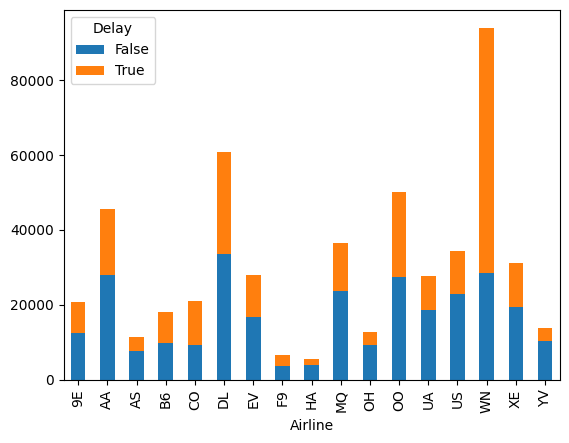

In [ ]:

# Reset the index to ensure it starts from 0 and is consecutive
df.reset_index(drop=True, inplace=True)

# Add a new column named 'ID'
df['ID'] = df.index + 1  # Index starts from 0, so we add 1

df_pivot = pd.pivot_table(df, index='Airline', columns='Delay',values='ID',  aggfunc='count').fillna(0)
plt.figure(figsize=(10,7))
df_pivot.plot.bar(stacked=True)
plt.show()


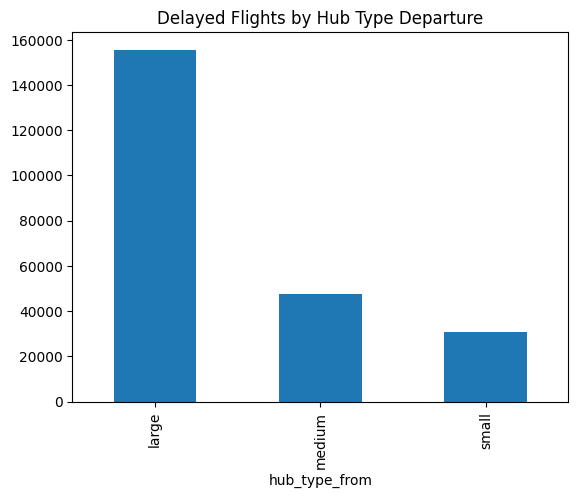

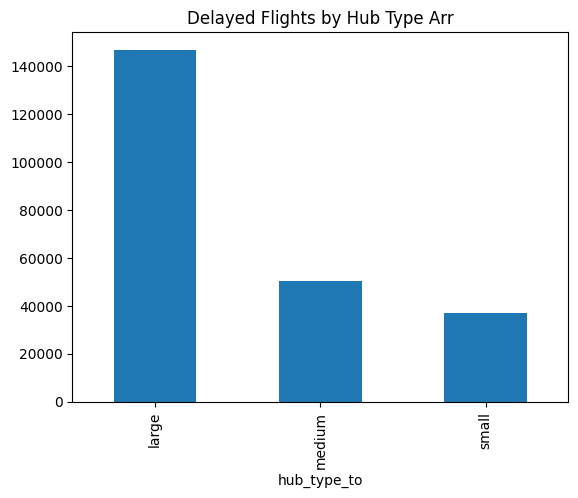

In [ ]:
# Visualization: Delayed flights by hub type departure
delayed_by_hub_from = df[df['Delay'] == True].groupby('hub_type_from').size().plot(kind='bar')
plt.title('Delayed Flights by Hub Type Departure')
plt.show()
#Plot dealy vs Arr airfd hub type
delayed_by_hub_to = df[df['Delay'] == True].groupby('hub_type_to').size().plot(kind='bar')
plt.title('Delayed Flights by Hub Type Arr')
plt.show()

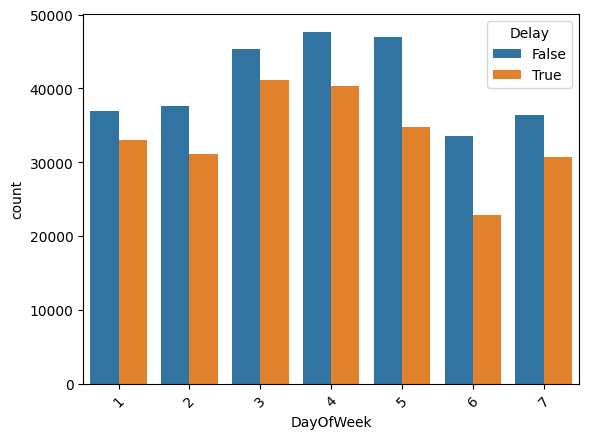

In [ ]:
# Create a count plot of DayOfWeek vs Delay
sns.countplot(
    x = 'DayOfWeek',
    hue = 'Delay',
    data = df
)

# Rotate x labels to prevent overlapping
plt.xticks(rotation=45)
plt.show()

Feature engineering

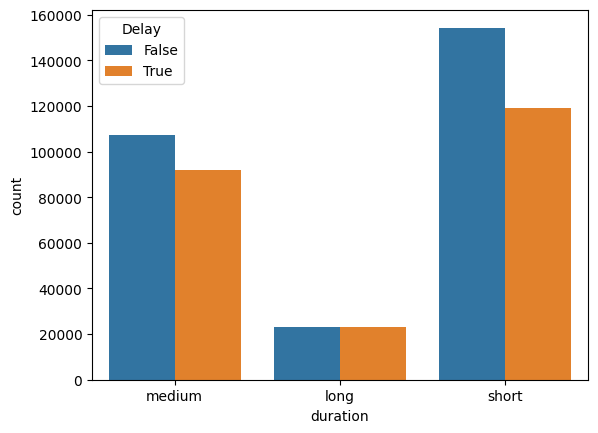

In [ ]:
# Create the 'duration' field
def categorize_duration(row):
    if row['Length'] < 120:
        return 'short'
    elif 120 <= row['Length'] < 240:
        return 'medium'
    else:
        return 'long'

df['duration'] = df.apply(categorize_duration, axis=1)

# Plot duration vs. delay
sns.countplot(x='duration', hue='Delay', data=df)
plt.show()



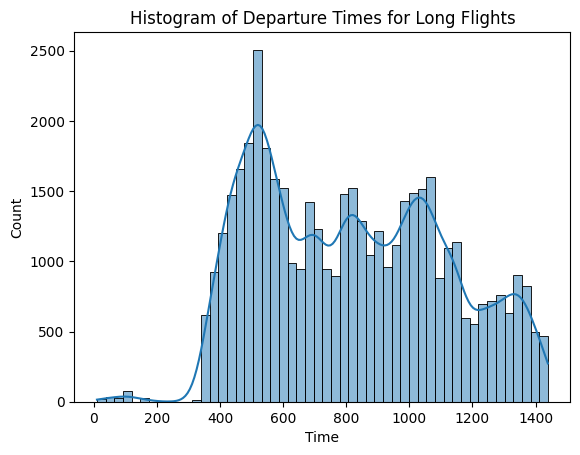

In [ ]:
# Filter for long duration flights
long_flights = df[df['duration'] == 'long']

# Create the histogram
sns.histplot(long_flights['Time'], kde=True)  # kde=True adds a density curve
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Histogram of Departure Times for Long Flights')
plt.show()

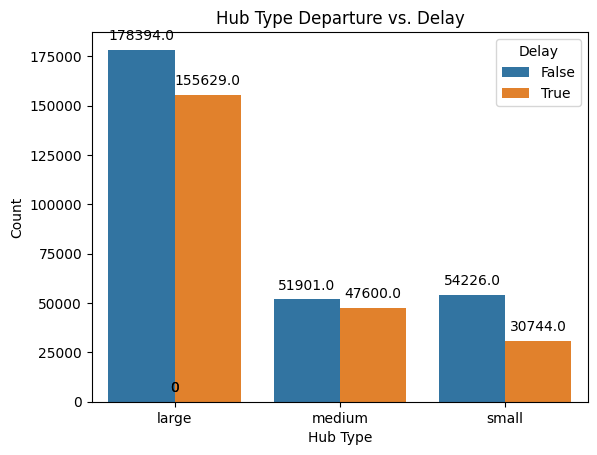

In [ ]:
# Plot hub vs. delay
sns.countplot(x='hub_type_from', hue='Delay', data=df)
# Get the current axes object
ax = plt.gca()
# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5),  # Offset slightly above the bar
                textcoords='offset points',
                ha='center', va='bottom')
# Customize the plot
plt.xlabel('Hub Type')
plt.ylabel('Count')
plt.title('Hub Type Departure vs. Delay')
plt.legend(title='Delay', loc='upper right')
plt.show()


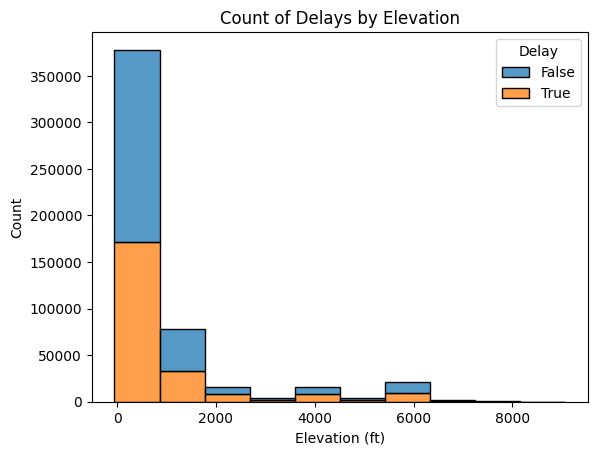

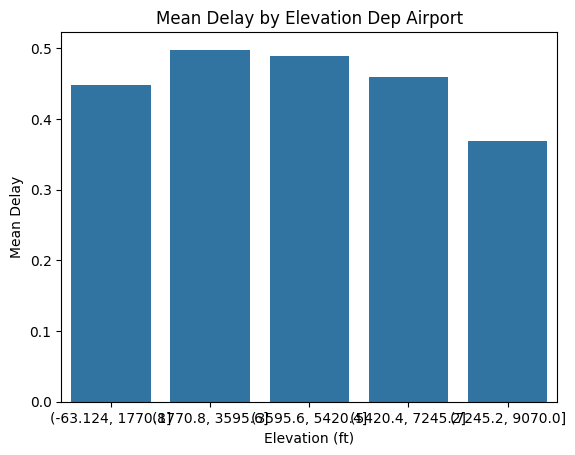

<Figure size 1200x2000 with 0 Axes>

t-statistic: 2.415435752905638
p-value: 0.015722462914667622


In [ ]:
# Define the number of bins (adjust as needed)
num_bins = 10

# Create the histogram
sns.histplot(
    df,
    x = 'elevation_ft_from',
    hue = 'Delay',  # Separate histograms for delays vs non-delays
    bins = num_bins,
    multiple = 'stack'  # Stack the histograms on top of each other
)
plt.xlabel('Elevation (ft)')
plt.ylabel('Count')
plt.title('Count of Delays by Elevation')
plt.show()

# Calculate grouped means
# Define the number of bins (adjust as needed)
num_bins = 5

df_grouped = df.groupby(pd.cut(df['elevation_ft_from'], bins=num_bins))['Delay'].mean()

# Create the bar plot
sns.barplot(
    x = df_grouped.index.astype(str),  # Convert bin labels to string for plotting
    y = df_grouped.values
)
plt.xlabel('Elevation (ft)')
plt.ylabel('Mean Delay')
plt.title('Mean Delay by Elevation Dep Airport')
plt.figure(figsize=(12, 20))
plt.show()
# Hypothesis testing (example: effect of airport elevation on delays)
from scipy.stats import ttest_ind

high_elev =df[df['elevation_ft_from'] > 5000]
low_elev = df[df['elevation_ft_from'] <= 5000]

t_stat, p_value = ttest_ind(high_elev['Delay'], low_elev['Delay'], equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)


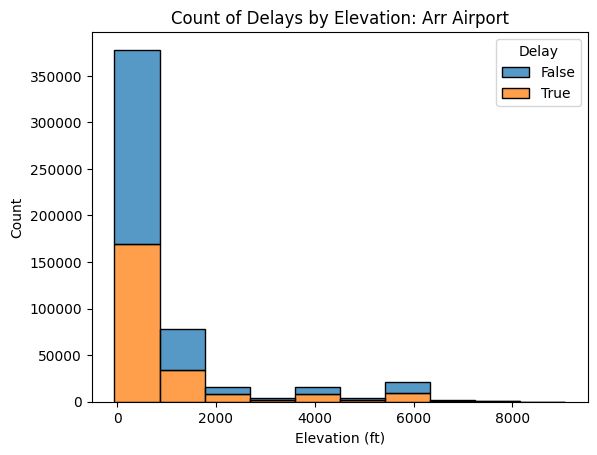

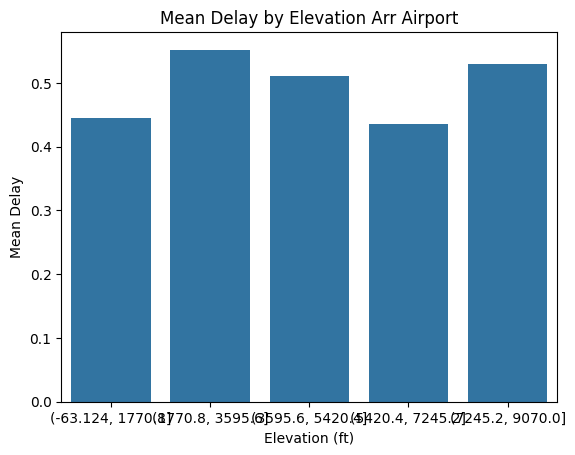

<Figure size 1200x2000 with 0 Axes>

t-statistic: 0.7498156315532386
p-value: 0.4533717588728631


In [ ]:

# Define the number of bins (adjust as needed)
num_bins = 10

# Create the histogram
sns.histplot(
    df,
    x = 'elevation_ft_to',
    hue = 'Delay',  # Separate histograms for delays vs non-delays
    bins = num_bins,
    multiple = 'stack'  # Stack the histograms on top of each other
)
plt.xlabel('Elevation (ft)')
plt.ylabel('Count')
plt.title('Count of Delays by Elevation: Arr Airport')
plt.show()

# Calculate grouped means
# Define the number of bins (adjust as needed)
num_bins = 5

df_grouped = df.groupby(pd.cut(df['elevation_ft_to'], bins=num_bins))['Delay'].mean()

# Create the bar plot (using barplot for flexibility)
sns.barplot(
    x = df_grouped.index.astype(str),  # Convert bin labels to string for plotting
    y = df_grouped.values
)
plt.xlabel('Elevation (ft)')
plt.ylabel('Mean Delay')
plt.title('Mean Delay by Elevation Arr Airport')
plt.figure(figsize=(12, 20))
plt.show()
# Hypothesis testing (example: effect of airport elevation on delays)
from scipy.stats import ttest_ind

high_elev =df[df['elevation_ft_to'] > 5000]
low_elev = df[df['elevation_ft_to'] <= 5000]

t_stat, p_value = ttest_ind(high_elev['Delay'], low_elev['Delay'], equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)


Correlation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518494 entries, 0 to 518493
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              518494 non-null  int64  
 1   Airline                 518494 non-null  object 
 2   AirportFrom             518494 non-null  object 
 3   AirportTo               518494 non-null  object 
 4   DayOfWeek               518494 non-null  int64  
 5   Time                    518494 non-null  int64  
 6   Length                  518494 non-null  int64  
 7   Delay                   518494 non-null  bool   
 8   type_from               518494 non-null  object 
 9   elevation_ft_from       518494 non-null  int64  
 10  iata_code_from          518494 non-null  object 
 11  length_ft_from          518494 non-null  int64  
 12  width_ft_from           518494 non-null  int64  
 13  lighted_from            518494 non-null  int64  
 14  number_of_runways_fr

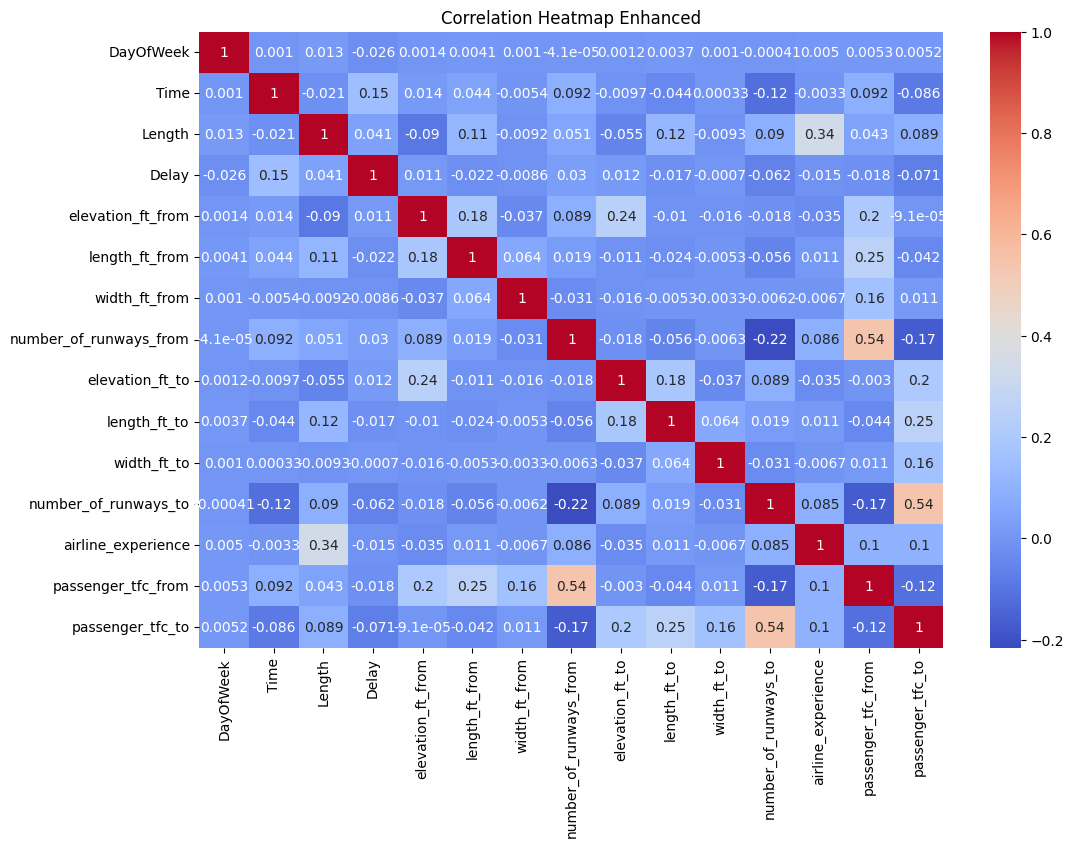

In [ ]:
df.info()
df.columns
# Select relevant numerical features for correlation analysis
predictors = ['DayOfWeek', 'Time', 'Length',
       'Delay',  'elevation_ft_from',
       'length_ft_from', 'width_ft_from',
       'number_of_runways_from', 'elevation_ft_to',
       'length_ft_to', 'width_ft_to',
       'number_of_runways_to',
       'airline_experience', 'passenger_tfc_from',
       'passenger_tfc_to' ]
corr_matrix = df[predictors].corr()

# Heatmap visualization
import seaborn as sns
# Increase size
plt.figure(figsize=(12, 8))  # Adjust width and height as desired

# Select a colormap:
cmap = sns.color_palette("coolwarm", as_cmap=True)  # Try other palettes!

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap=cmap)
plt.title('Correlation Heatmap Enhanced')
plt.show()
# Convert the correlation matrix to a DataFrame (if it isn't already)
if not isinstance(corr_matrix, pd.DataFrame):
    corr_matrix = pd.DataFrame(corr_matrix)

# Export to Excel
corr_matrix.to_excel(file_path +'correlation_matrix.xlsx', index=True)
# 'index=True' will include the row and column labels

## Machine learning

In [ ]:
df.columns
df['type_to'].unique()
# Drop unnecessary columns from df
df=df.drop(['passenger_tfc_from','passenger_tfc_to','elevation_ft','iata_code_from','iata_code_to','airport_ident'],axis=1)
df=df.drop(['iata_code'],axis=1)

# Assuming 'AirportFrom' is already in the categorical_features list
encoder = OrdinalEncoder()
df['AirportFrom_encode'] = encoder.fit_transform(df[['AirportFrom']])
df['AirportFrom'].nunique()
df=df.drop(['AirportFrom_encode'],axis=1)

df.columns
df.shape


(518494, 25)

##Label encode
I am encoding it out of the pipeline due to repeted errors

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Airline'] = le.fit_transform(df['Airline'])
df['AirportFrom'] = le.fit_transform(df['AirportFrom'])
df['AirportTo'] = le.fit_transform(df['AirportTo'])
df.head()

,Unnamed: 0,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_from,elevation_ft_from,...,length_ft_to,width_ft_to,lighted_to,number_of_runways_to,type_to,airline_experience,hub_type_from,hub_type_to,ID,duration
0,0,4,251,133,3,15,205,True,large_airport,13,...,9000,150,1,5,large_airport,87.0,large,large,1,medium
1,1,13,215,59,3,15,222,True,large_airport,1135,...,7502,150,1,4,large_airport,87.0,large,large,2,medium
2,2,1,152,78,3,20,165,True,large_airport,125,...,9000,200,1,7,large_airport,97.0,large,large,3,medium
3,3,1,251,78,3,20,195,True,large_airport,13,...,9000,200,1,7,large_airport,97.0,large,large,4,medium
4,4,2,13,250,3,30,202,False,large_airport,152,...,9426,150,1,4,large_airport,91.0,medium,large,5,medium


## Pipeline Model Fitting and testing
This is the main ML codeblock where ppl has been used to encode categorical data and model fitting is done in a loop. This is a very useful and resusable code 🥰

In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier

# Assuming 'delay' is your target variable (binary: delayed or not)
X = df[['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'type_from', 'elevation_ft_from',
       'length_ft_from', 'width_ft_from', 'lighted_from',
       'number_of_runways_from', 'elevation_ft_to', 'length_ft_to',
       'width_ft_to', 'lighted_to', 'number_of_runways_to', 'type_to',
       'airline_experience', 'hub_type_from', 'hub_type_to']]
y = df['Delay']



# Identify Feature Types
ordinal_features = ['type_from','type_to','hub_type_from', 'hub_type_to']  # Replace with your actual ordinal features
numerical_features = ['DayOfWeek','Time', 'Length', 'elevation_ft_from','length_ft_from', 'width_ft_from',
       'number_of_runways_from', 'elevation_ft_to', 'length_ft_to',
       'width_ft_to', 'number_of_runways_to',
       'airline_experience',]  # Your numerical features
airport_type_order = ['small_airport', 'medium_airport', 'large_airport']  # Order for 'type_from', 'type_to'
hub_type_order=['large', 'medium', 'small']
ordinal_order=[airport_type_order,airport_type_order,hub_type_order,hub_type_order]


# Build the Pipeline
preprocessor = ColumnTransformer(
    transformers=[

        ('oe_type', OrdinalEncoder(categories='auto'), ordinal_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)



# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Model Building
models = {
'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),  # Example depth control
    # Hyper tuning parameter set
    'Gradient Boosting': GradientBoostingClassifier(max_depth=8, n_estimators=100),
    # tuning hyper parameters based on grid search
    'Random Forest Classifier' : RandomForestClassifier(max_depth= 8, min_samples_split= 10, n_estimators=200)
}

# Stratified K-Fold for voting
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    accuracy_scores = []
    for train_index, test_index in skf.split(X_train_transformed, y_train):
        X_train_fold, y_train_fold = X_train_transformed[train_index], y_train.iloc[train_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_train_transformed[test_index])
        accuracy = accuracy_score(y_train.iloc[test_index], y_pred)
        accuracy_scores.append(accuracy)
    print(f"{name} Average Accuracy: {np.mean(accuracy_scores):.3f}")
    #print(f'{name} feature of importance :{model.coeff}')

Logistic Regression Average Accuracy: 0.585
Decision Tree Average Accuracy: 0.634
Gradient Boosting Average Accuracy: 0.666
Random Forest Classifier Average Accuracy: 0.645


Plot the gradient booster

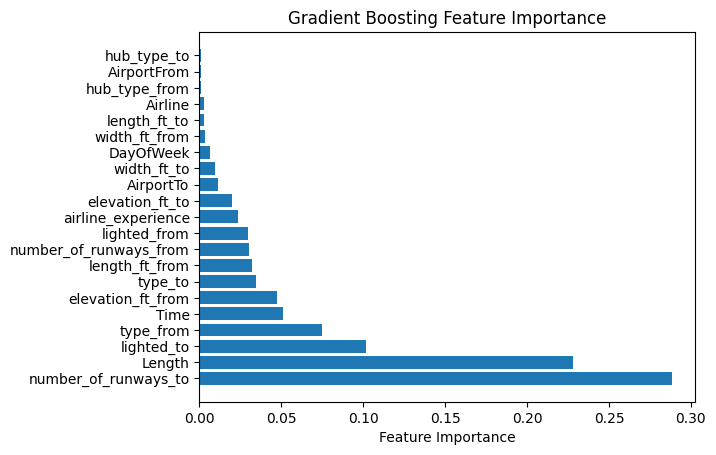

Top 10 Features (Gradient Boosting):
number_of_runways_to: 0.288
Length: 0.228
lighted_to: 0.102
type_from: 0.075
Time: 0.051
elevation_ft_from: 0.048
type_to: 0.035
length_ft_from: 0.032
number_of_runways_from: 0.030
lighted_from: 0.030


In [ ]:
import matplotlib.pyplot as plt

model = models['Gradient Boosting']
feature_importances = model.feature_importances_
feature_names = X.columns  # Or update with transformed column names
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort importances

plt.barh(feature_names[sorted_indices], feature_importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()

#Print top features
print('Top 10 Features (Gradient Boosting):')
for i in sorted_indices[:10]:  # Print the top 10
    print(f'{feature_names[i]}: {feature_importances[i]:.3f}')

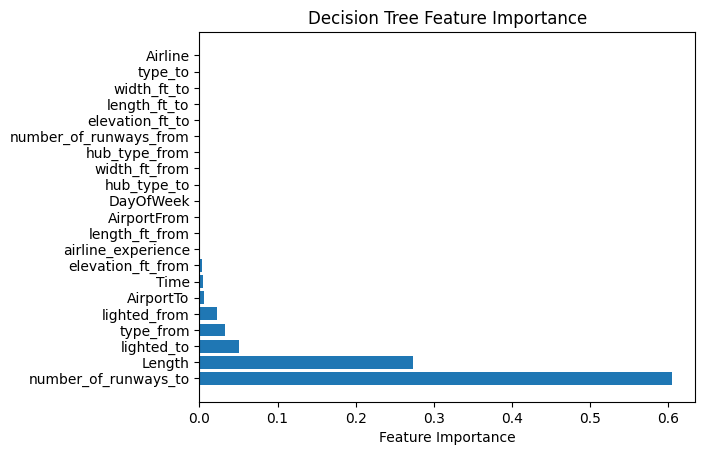

Top 10 Features (Decision Tree):
number_of_runways_to: 0.605
Length: 0.273
lighted_to: 0.051
type_from: 0.033
lighted_from: 0.023
AirportTo: 0.006
Time: 0.004
elevation_ft_from: 0.004
airline_experience: 0.001
length_ft_from: 0.000


In [ ]:
# Plot Decision tree model
model = models['Decision Tree']
feature_importances = model.feature_importances_
feature_names = X.columns  # Or update with transformed column names
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort importances

plt.barh(feature_names[sorted_indices], feature_importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

#Print top features
print('Top 10 Features (Decision Tree):')
for i in sorted_indices[:10]:  # Print the top 10
    print(f'{feature_names[i]}: {feature_importances[i]:.3f}')

Top 10 features with models


Plot for Random Forest

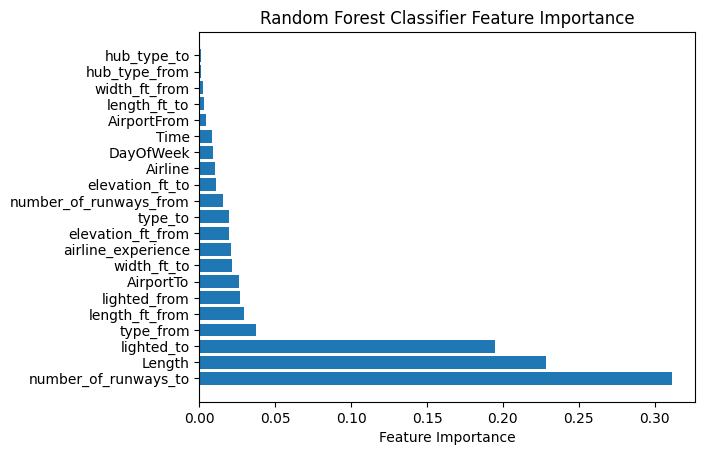

Top 10 Features (Random Forest Classifier):
number_of_runways_to: 0.311
Length: 0.229
lighted_to: 0.195
type_from: 0.037
length_ft_from: 0.029
lighted_from: 0.027
AirportTo: 0.026
width_ft_to: 0.021
airline_experience: 0.021
elevation_ft_from: 0.020


In [ ]:

model = models['Random Forest Classifier']
feature_importances = model.feature_importances_
feature_names = X.columns  # Or update with transformed column names
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort importances

plt.barh(feature_names[sorted_indices], feature_importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier Feature Importance")
plt.show()

#Print top features
print('Top 10 Features (Random Forest Classifier):')
for i in sorted_indices[:10]:  # Print the top 10
    print(f'{feature_names[i]}: {feature_importances[i]:.3f}')

## Hyper parameter tuning

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
# Tese Parameter I fed into model and refitted

Best Hyperparameters: {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}


hyper tune got XGB classified

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", message="Parameters: { 'min_samples_split' } are not used")

# Define the parameter grid (same as  before, suitable for XGBoost)
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [3, 5, 8],
}

# Create XGBoost model instance
xgb_model = XGBClassifier(random_state=42)

# Setup GridSearchCV with XGBoost
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
# Tese Parameter I fed into model and refitted

Best Hyperparameters: {'max_depth': 8, 'n_estimators': 100}


## Hypotheis testing - Number runways
Hypothesis:

Null Hypothesis (H0): There is no significant relationship between the number of runways at an airport and average flight delays.
Alternative Hypothesis (H1): Airports with more runways tend to have lower average flight delays.

In [ ]:
import pandas as pd
import scipy.stats as stats

# ... (Load your data)

# Create a contingency table
contingency_table = pd.crosstab(df['number_of_runways_from'], df['Delay'])

# Perform Chi-Squared test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared Statistic:", chi2_stat)
print("p-value of Chi test:", p_value)
# Normalize frequencies in the contingency table
contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Plot stacked bars
contingency_table_norm.plot(kind='bar', stacked=True)
plt.xlabel("Number of Runways (Departure Airport)")
plt.ylabel("Proportion of Flights")
plt.title("Proportion of Delayed vs. Non-Delayed Flights by Number of Runways")
plt.legend(['Not Delayed', 'Delayed'])
plt.show()

## hypothesis about flight length and delays
Hypotheses

Null Hypothesis (H0): There is no significant relationship between flight duration (length) and the likelihood of flight delays.
Alternative Hypothesis (H1): There is a relationship between flight duration and the likelihood of flight delays (this could be either that longer flights are more likely to be delayed, or less likely to be delayed).
Testing Approach
As my target variabel is binary. I will use Chi test

In [ ]:
import pandas as pd
import scipy.stats as stats


# Categorize flight lengths
df['length_category'] = pd.cut(df['Length'],
                                        bins=[0, 120, 240, df['Length'].max()],
                                        labels=['Short', 'Medium', 'Long'])

# Contingency table
contingency_table = pd.crosstab(df['length_category'], df['Delay'])

# Chi-Squared test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print('Chi-squared statistic:', chi2_stat)
print('p-value:', p_value)
# Visualisation of Chi test
# Normalize frequencies in the contingency table
contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Plot stacked bars
contingency_table_norm.plot(kind='bar', stacked=True)
plt.xlabel("Flight Length Category")
plt.ylabel("Proportion of Flights")
plt.title("Proportion of Delayed vs. Non-Delayed Flights by Flight Length")
plt.legend(['Not Delayed', 'Delayed'])
plt.show()